In [1]:
import pulp
import numpy as np
import matplotlib.pyplot as plt
import time

# Cybsec_L

## Original

Budget = 100
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/518b0fffa3914c42aec1b66dfbcc18c3-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/518b0fffa3914c42aec1b66dfbcc18c3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1786 COLUMNS
At line 13167 RHS
At line 14949 BOUNDS
At line 15750 ENDATA
Problem MODEL has 1781 rows, 1610 columns and 9170 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.69246e+07 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 30 substitutions
Cgl0004I processed model has 731 rows, 890 columns (360 integer (360 of which binary)) and 2660 elements
Cbc0038I Initial state - 5 integers unsatisfied sum - 0.752931
Cbc0038I Pass   1: suminf.    0.10000 (1) obj. 1.69792e+07 iterations 5
Cb

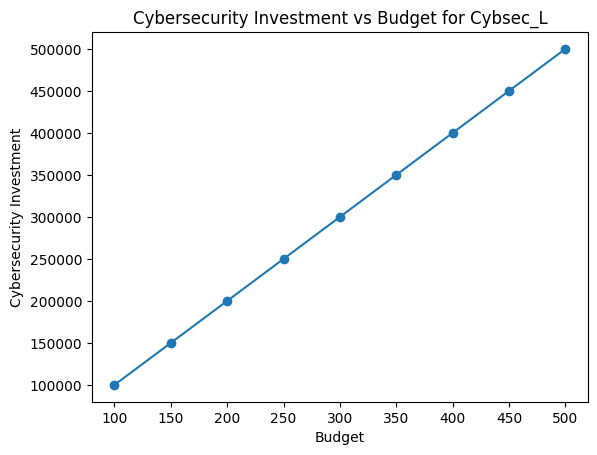

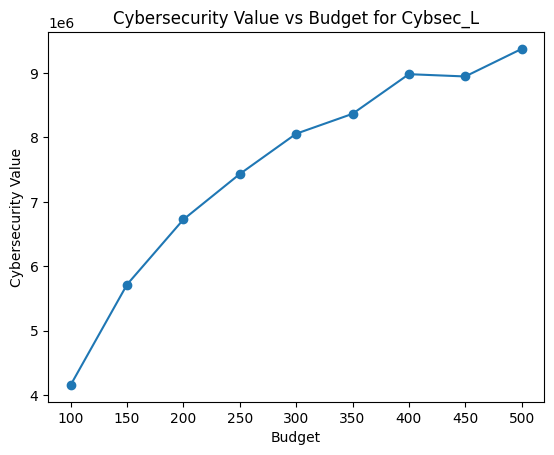

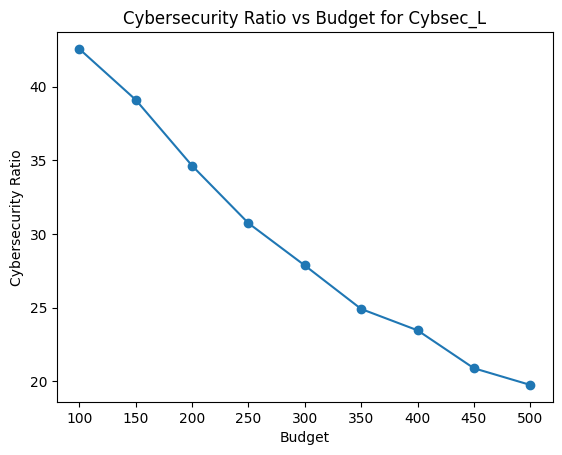

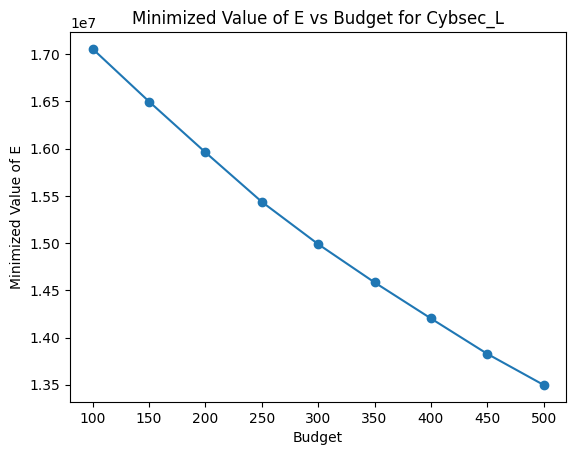

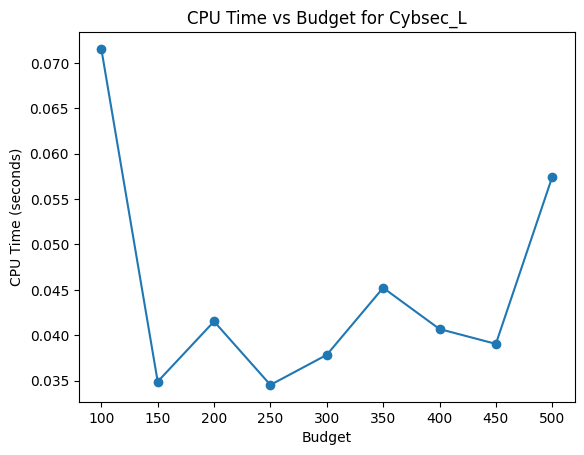

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def minimize_cost(c, d, p, q, V, r, budget):
    num_nodes = len(d)
    num_safeguards = len(q)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Minimize_Cost", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
                # else:
                #     prob += (pulp.lpSum(r[i][j][l] * v[i, j, l_prime] for l_prime in range(num_levels))== 0)

    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))

    # Budget constraint
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # Define objective function
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) + pulp.lpSum(p[i] * d[i] * W[i] for i in range(num_nodes))

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
           
    print("W")
    for i in range(num_nodes):
        print(f"W[{i}] = {W[i].varValue}")

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Cybersecurity gained
    cybersecurity_gained = sum(p[i] * d[i] * V[i] * (1 - np.prod([np.sum([r[i][j][l_prime] * u[i, j, l_prime].varValue for l_prime in range(num_levels)]) for j in range(num_safeguards) for l in range(num_levels)])) for i in range(num_nodes))
    
    # Cybersecurity value
    cybersecurity_value = cybersecurity_gained - cybersecurity_investment

    # Cybersecurity ratio
    cybersecurity_ratio = cybersecurity_gained / cybersecurity_investment

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    print("Cybersecurity Value:", cybersecurity_value/1000)
    print("Cybersecurity Ratio:", cybersecurity_ratio)
    print("Minimized Value of E:", minimized_value/1000)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment, cybersecurity_value, cybersecurity_ratio, minimized_value, end_time - start_time


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Calculate r
r = calculate_r(V, q, c)
budgets = range(100, 501, 50)

cybersecurity_investments = []
cybersecurity_values = []
cybersecurity_ratios = []
minimized_values = []
cpu_times = []

for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, value, ratio, minimized_value, cpu_time = minimize_cost(c, d, p, q, V, r, budget*1000)
    cybersecurity_investments.append(investment)
    cybersecurity_values.append(value)
    cybersecurity_ratios.append(ratio)
    minimized_values.append(minimized_value)
    cpu_times.append(cpu_time)
    print()

# Plotting
plt.figure()
plt.plot(budgets, cybersecurity_investments, marker='o')
plt.title('Cybersecurity Investment vs Budget for Cybsec_L')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Investment')
plt.show()

plt.figure()
plt.plot(budgets, cybersecurity_values, marker='o')
plt.title('Cybersecurity Value vs Budget for Cybsec_L')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Value')
plt.show()

plt.figure()
plt.plot(budgets, cybersecurity_ratios, marker='o')
plt.title('Cybersecurity Ratio vs Budget for Cybsec_L')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Ratio')
plt.show()

plt.figure()
plt.plot(budgets, minimized_values, marker='o')
plt.title('Minimized Value of E vs Budget for Cybsec_L')
plt.xlabel('Budget')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(budgets, cpu_times, marker='o')
plt.title('CPU Time vs Budget for Cybsec_L')
plt.xlabel('Budget')
plt.ylabel('CPU Time (seconds)')
plt.show()


## With Network (DAG)

Budget = 10
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/539b634fde344d50b81c4c045cdbff3b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/539b634fde344d50b81c4c045cdbff3b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1796 COLUMNS
At line 13199 RHS
At line 14991 BOUNDS
At line 15792 ENDATA
Problem MODEL has 1791 rows, 1610 columns and 9192 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Problem is infeasible - 0.00 seconds
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.02

Status: Infeasible
Final Decision Variables:
W
W[0] = -0.66103302
W[1] = 1.9388462
W[2] = 0.40825556
W[3] = 0.5067
W[4] = 0.7799
W[5] = 0.42794444
W[6] = 0.8976
W[7] = 0.8821
W[8] = 0.9772
W[9] = 0.9939
Optimal Co

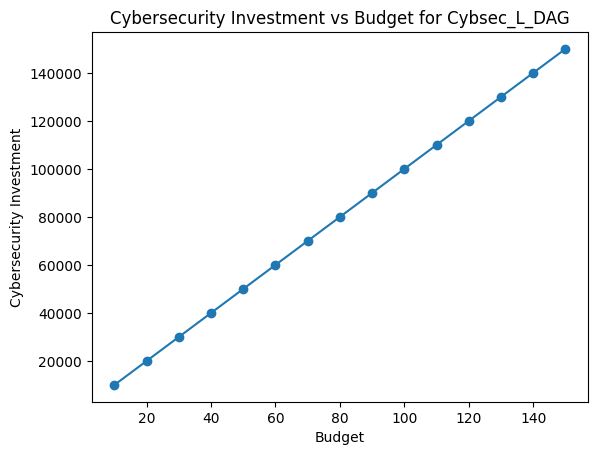

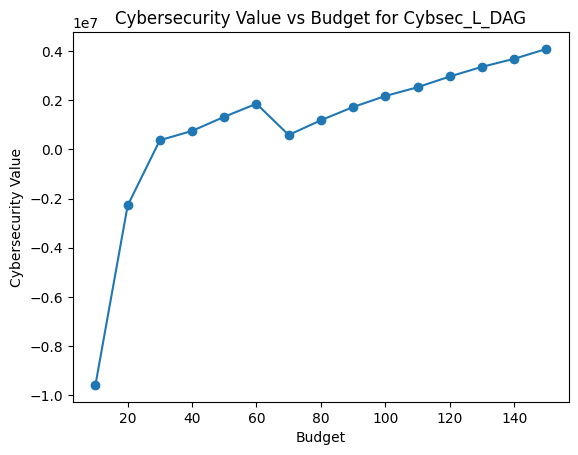

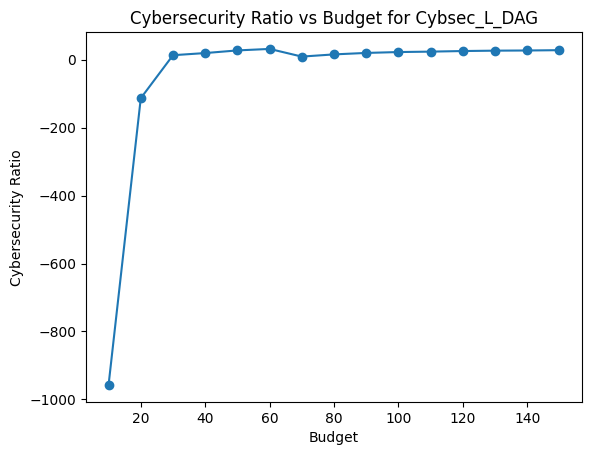

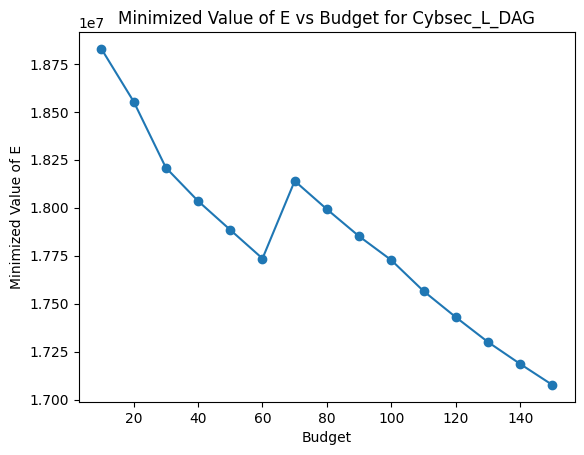

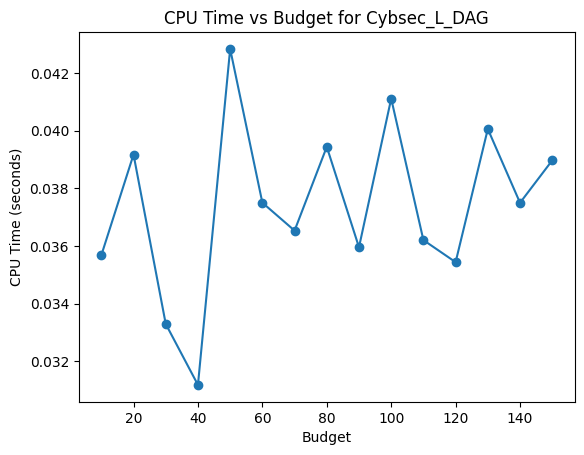

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def minimize_cost(c, d, p, q, V, r, budget, q_ih):
    num_nodes = len(d)
    num_safeguards = len(q)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Minimize_Cost", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
                
    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))

    # Budget constraint
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # Adjust vulnerability values with propagation probabilities
    for i in range(num_nodes):
        propagated_vulnerability = pulp.lpSum(q_ih[h, i] * W[h] for h in range(num_nodes) if q_ih[h, i] > 0)
        prob += W[i] >= propagated_vulnerability


    # Define objective function
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) + pulp.lpSum(p[i] * d[i] * W[i] for i in range(num_nodes))

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
               
    print("W")
    for i in range(num_nodes):
        print(f"W[{i}] = {W[i].varValue}")

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Cybersecurity gained
    cybersecurity_gained = sum(p[i] * d[i] * V[i] * (1 - np.prod([np.sum([r[i][j][l_prime] * u[i, j, l_prime].varValue for l_prime in range(num_levels)]) for j in range(num_safeguards) for l in range(num_levels)])) for i in range(num_nodes))
    
    # Cybersecurity value
    cybersecurity_value = cybersecurity_gained - cybersecurity_investment

    # Cybersecurity ratio
    cybersecurity_ratio = cybersecurity_gained / cybersecurity_investment

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    print("Cybersecurity Value:", cybersecurity_value/1000)
    print("Cybersecurity Ratio:", cybersecurity_ratio)
    print("Minimized Value of E:", minimized_value/1000)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment, cybersecurity_value, cybersecurity_ratio, minimized_value, end_time - start_time


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    # print(r)
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
p = [0.35, 0.40, 0.35, 0.25, 0.40, 0.25, 0.55, 0.55, 0.75, 0.75]
d_temp = [450, 1500, 550, 300, 1200, 350, 2500, 2500, 10000, 10000]
d = [value * 1000 for value in d_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Define the adjacency matrix for q_ih (replace the values with your specified probabilities)
q_ih = np.zeros((len(c_light), len(c_light)))
q_ih[0, 2] = 0.3
q_ih[0, 3] = 0.7
q_ih[1, 3] = 0.5
q_ih[2, 4] = 0.4
q_ih[2, 5] = 0.8
q_ih[3, 5] = 0.2
q_ih[4, 6] = 0.6
q_ih[5, 7] = 0.9
q_ih[6, 8] = 0.1
q_ih[7, 8] = 0.4
q_ih[8, 9] = 0.7
q_ih[9, 7] = 0.5

# Calculate r
r = calculate_r(V, q, c)
budgets = range(10, 151, 10)

cybersecurity_investments = []
cybersecurity_values = []
cybersecurity_ratios = []
minimized_values = []
cpu_times = []

for budget in budgets:
    print("Budget =", budget)
    
    # Solve the optimization problem and collect results
    investment, value, ratio, minimized_value, cpu_time = minimize_cost(c, d, p, q, V, r, budget*1000, q_ih)
    cybersecurity_investments.append(investment)
    cybersecurity_values.append(value)
    cybersecurity_ratios.append(ratio)
    minimized_values.append(minimized_value)
    cpu_times.append(cpu_time)
    print()

# Plotting
plt.figure()
plt.plot(budgets, cybersecurity_investments, marker='o')
plt.title('Cybersecurity Investment vs Budget for Cybsec_L_DAG')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Investment')
plt.show()

plt.figure()
plt.plot(budgets, cybersecurity_values, marker='o')
plt.title('Cybersecurity Value vs Budget for Cybsec_L_DAG')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Value')
plt.show()

plt.figure()
plt.plot(budgets, cybersecurity_ratios, marker='o')
plt.title('Cybersecurity Ratio vs Budget for Cybsec_L_DAG')
plt.xlabel('Budget')
plt.ylabel('Cybersecurity Ratio')
plt.show()

plt.figure()
plt.plot(budgets, minimized_values, marker='o')
plt.title('Minimized Value of E vs Budget for Cybsec_L_DAG')
plt.xlabel('Budget')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(budgets, cpu_times, marker='o')
plt.title('CPU Time vs Budget for Cybsec_L_DAG')
plt.xlabel('Budget')
plt.ylabel('CPU Time (seconds)')
plt.show()


# Cybsec_BW

## Original

Budget =  100
Lambda =  0.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/d887c76017fd4793ab2192fbdfd93c35-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/d887c76017fd4793ab2192fbdfd93c35-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1807 COLUMNS
At line 12659 RHS
At line 14462 BOUNDS
At line 15275 ENDATA
Problem MODEL has 1802 rows, 1622 columns and 9230 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 30 substitutions
Cgl0004I processed model has 752 rows, 911 columns (370 integer (370 of which binary)) and 2750 elements
Cbc0038I Initial state - 23 integers unsatisfied sum - 3.43841
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 0.464892 iterations 69

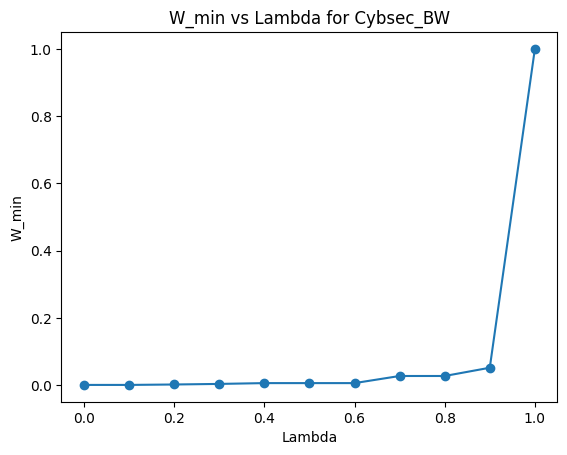

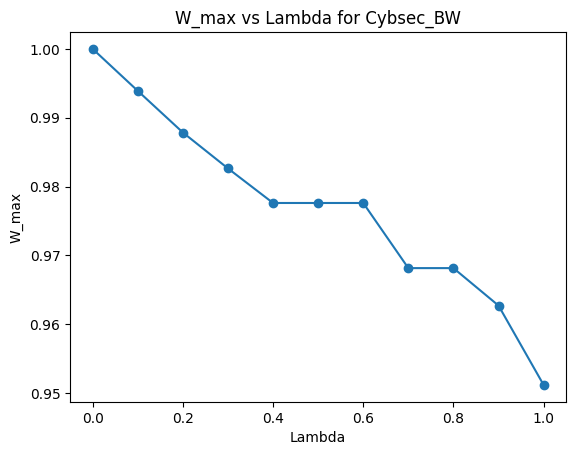

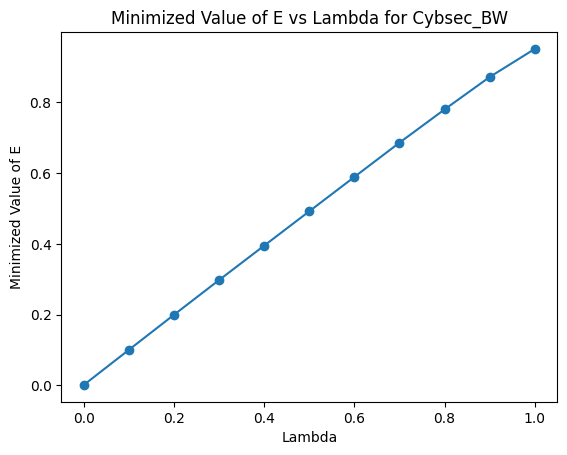

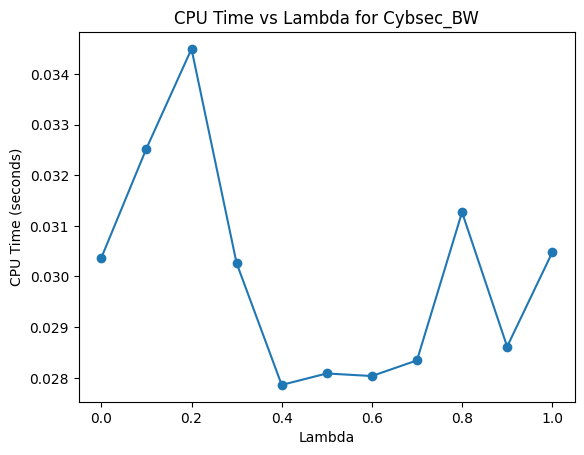

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def minimize_cost(c, q, V, r, budget, lambda_val):
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Minimize_Cost", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node
    W_min = pulp.LpVariable("W_min", lowBound=0, upBound=1)
    W_max = pulp.LpVariable("W_max", lowBound=0, upBound=1)
    x = pulp.LpVariable.dicts("x", (i for i in range(num_nodes)), cat="Binary")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))
               
    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))
    # W_max ≥ W_i
    for i in range(num_nodes):
        prob += W_max >= W[i]

    # W_min ≥ W_i - (1 - x_i)
    for i in range(num_nodes):
        prob += W_min >= W[i] - (1 - x[i])

    # Sum of x_i across all i ∈ I must equal 1
    prob += pulp.lpSum(x[i] for i in range(num_nodes)) == 1

    # Budget constraint
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
    
    # Objective function
    prob += (1 - lambda_val) * W_min + lambda_val * W_max

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
               
    print("W")
    for i in range(num_nodes):
        print(f"W[{i}] = {W[i].varValue}")

    print("W_min = ", W_min.varValue)
    
    print("W_max = ", W_max.varValue)

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    # print("Cybersecurity Value:", cybersecurity_value/1000)
    # print("Cybersecurity Ratio:", cybersecurity_ratio)
    print("Minimized Value of E:", minimized_value/1000)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment, W_min.varValue, W_max.varValue, minimized_value, end_time - start_time


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    # print(r)
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Calculate r
r = calculate_r(V, q, c)
budget = 100
lambda_val = np.arange(0.0, 1.01, 0.1)  # Set the desired value for λ

cybersecurity_investments = []
W_mins = []
W_maxs = []
minimized_values = []
cpu_times = []
print("Budget = ", budget)
for lambda_v in lambda_val:
    print("Lambda = ", lambda_v)
    # Solve the optimization problem and collect results
    investment, W_min, W_max, minimized_value, cpu_time = minimize_cost(c, q, V, r, budget*1000, lambda_v)
    cybersecurity_investments.append(investment)
    W_mins.append(W_min)
    W_maxs.append(W_max)
    minimized_values.append(minimized_value)
    cpu_times.append(cpu_time)
    print()

# Plotting

# plt.figure()
# plt.plot(lambda_val, cybersecurity_investments, marker='o')
# plt.title('Cybersecurity Investment vs Lambda for Cybsec_BW')
# plt.xlabel('Lambda')
# plt.ylabel('Cybersecurity Investment')
# plt.show()

plt.figure()
plt.plot(lambda_val, W_mins, marker='o')
plt.title('W_min vs Lambda for Cybsec_BW')
plt.xlabel('Lambda')
plt.ylabel('W_min')
plt.show()

plt.figure()
plt.plot(lambda_val, W_maxs, marker='o')
plt.title('W_max vs Lambda for Cybsec_BW')
plt.xlabel('Lambda')
plt.ylabel('W_max')
plt.show()

plt.figure()
plt.plot(lambda_val, minimized_values, marker='o')
plt.title('Minimized Value of E vs Lambda for Cybsec_BW')
plt.xlabel('Lambda')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(lambda_val, cpu_times, marker='o')
plt.title('CPU Time vs Lambda for Cybsec_BW')
plt.xlabel('Lambda')
plt.ylabel('CPU Time (seconds)')
plt.show()


## With Network (DAG)

Budget =  100
Lambda =  0.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f4016918390b400da69d8e17f3d62305-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f4016918390b400da69d8e17f3d62305-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1817 COLUMNS
At line 12691 RHS
At line 14504 BOUNDS
At line 15317 ENDATA
Problem MODEL has 1812 rows, 1622 columns and 9252 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 30 substitutions
Cgl0004I processed model has 760 rows, 911 columns (370 integer (370 of which binary)) and 2770 elements
Cbc0038I Initial state - 21 integers unsatisfied sum - 4.16371
Cbc0038I Pass   1: suminf.    0.82674 (4) obj. 0.605884 iterations 72

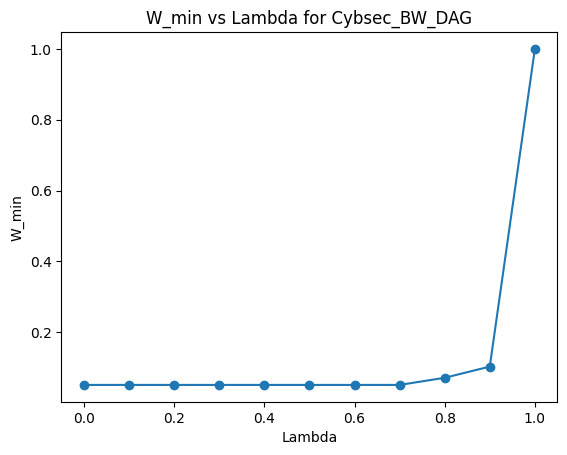

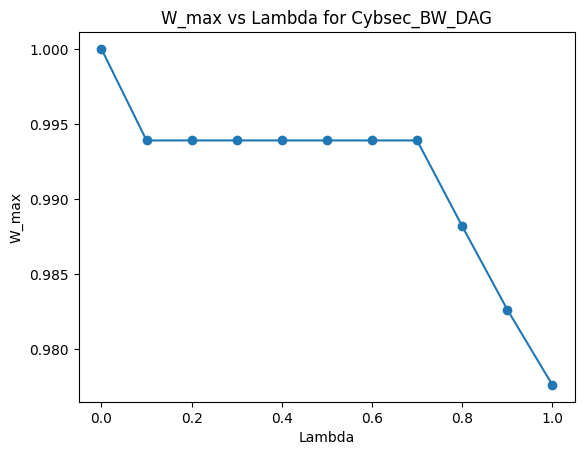

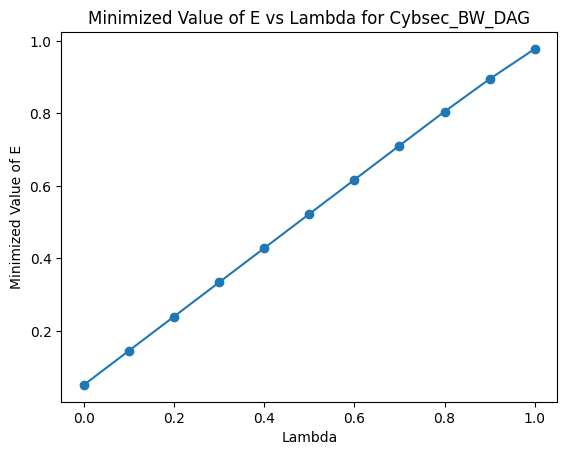

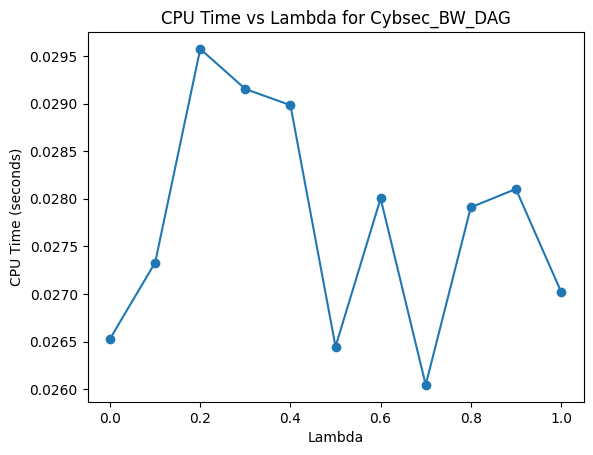

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pulp

def minimize_cost(c, q, V, r, budget, lambda_val, q_ih):
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])

    # Initialize problem
    prob = pulp.LpProblem("Minimize_Cost", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), cat='Binary', lowBound=0) # final decision variable
    v = pulp.LpVariable.dicts("v", ((i, j, l) for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)), lowBound=0) # vulnerability at level l
    W = pulp.LpVariable.dicts("W", (i for i in range(num_nodes)), lowBound=0) # final vulnerability of node
    W_min = pulp.LpVariable("W_min", lowBound=0, upBound=1)
    W_max = pulp.LpVariable("W_max", lowBound=0, upBound=1)
    x = pulp.LpVariable.dicts("x", (i for i in range(num_nodes)), cat="Binary")

    # Define constraints
    for i in range(num_nodes):
        for j in range(num_safeguards):
            prob += (pulp.lpSum(u[i, j, l] for l in range(num_levels)) == 1)

    for i in range(num_nodes):
        prob += (pulp.lpSum(v[i, 0, l] for l in range(num_levels)) == V[i])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                prob += (v[i, j, l] <= u[i, j, l])

    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if j < num_safeguards - 1:
                    prob += (pulp.lpSum(r[i][j][l] * v[i, j, l] for l in range(num_levels)) == pulp.lpSum(v[i, j + 1, l] for l in range(num_levels)))

    for i in range(num_nodes):
        if num_safeguards == 1:
            prob += W[i] == pulp.lpSum(r[i][0][l] * v[i, 0, l] for l in range(num_levels))
        else:
            prob += W[i] == pulp.lpSum(r[i][num_safeguards-1][l] * v[i, num_safeguards-1, l] for l in range(num_levels))
    # W_max ≥ W_i
    for i in range(num_nodes):
        prob += W_max >= W[i]

    # W_min ≥ W_i - (1 - x_i)
    for i in range(num_nodes):
        prob += W_min >= W[i] - (1 - x[i])

    # Sum of x_i across all i ∈ I must equal 1
    prob += pulp.lpSum(x[i] for i in range(num_nodes)) == 1

    # Budget constraint
    prob += pulp.lpSum(c[j][l] * u[i, j, l] for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels)) <= budget
   
    # Adjust vulnerability values with propagation probabilities
    for i in range(num_nodes):
        propagated_vulnerability = pulp.lpSum(q_ih[h, i] * W[h] for h in range(num_nodes) if q_ih[h, i] > 0)
        prob += W[i] >= propagated_vulnerability

    # Objective function
    prob += (1 - lambda_val) * W_min + lambda_val * W_max

    # Start timer
    start_time = time.process_time()

    # Solve the problem
    prob.solve()

    # End timer
    end_time = time.process_time()

    # Print the status of the optimization
    print("Status:", pulp.LpStatus[prob.status])

    print("Final Decision Variables:")
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                if u[i, j, l].varValue > 0 & l>0:
                    print(f"u[{i}][{j}][{l}] = {u[i, j, l].varValue}")
             
    print("W")
    for i in range(num_nodes):
        print(f"W[{i}] = {W[i].varValue}")

    print("W_min = ", W_min.varValue)
    
    print("W_max = ", W_max.varValue)

    # Print the optimal cost
    print("Optimal Cost:", pulp.value(prob.objective))

    # Cybersecurity investment
    cybersecurity_investment = sum(c[j][l] * u[i, j, l].varValue for i in range(num_nodes) for j in range(num_safeguards) for l in range(num_levels))

    # Minimized value of E
    minimized_value = pulp.value(prob.objective)

    print("Cybersecurity Investment:", cybersecurity_investment/1000)
    # print("Cybersecurity Value:", cybersecurity_value/1000)
    # print("Cybersecurity Ratio:", cybersecurity_ratio)
    print("Minimized Value of E:", minimized_value/1000)
    print("Time taken for optimization (CPU seconds):", end_time - start_time)

    # Return results
    return cybersecurity_investment, W_min.varValue, W_max.varValue, minimized_value, end_time - start_time


def calculate_r(V, q, c):
    # Initialize r as a 3D array
    num_nodes = len(V)
    num_safeguards = len(q)
    num_levels = len(c[0])  # Assuming all safeguards have the same number of levels
    r = np.zeros((num_nodes, num_safeguards, num_levels))

    # Calculate r_ijl for each node, safeguard, and level
    for i in range(num_nodes):
        for j in range(num_safeguards):
            for l in range(num_levels):
                r[i][j][l] = V[i] ** (q[j] * c[j][l])
    # print(r)
    return r


c_light_temp = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]
c_light = [value * 1000 for value in c_light_temp]
c_medium = [5 * cost for cost in c_light]
c_strong = [10 * cost for cost in c_light]
c = [[0, c_light[i], c_medium[i], c_strong[i]] for i in range(len(c_light))]
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]
V = [0.6713, 0.7705, 0.6691, 0.5067, 0.7799, 0.5282, 0.8976, 0.8821, 0.9772, 0.9939]
# Define the adjacency matrix for q_ih (replace the values with your specified probabilities)
q_ih = np.zeros((len(c_light), len(c_light)))
q_ih[0, 2] = 0.3
q_ih[0, 3] = 0.7
q_ih[1, 3] = 0.5
q_ih[2, 4] = 0.4
q_ih[2, 5] = 0.8
q_ih[3, 5] = 0.2
q_ih[4, 6] = 0.6
q_ih[5, 7] = 0.9
q_ih[6, 8] = 0.1
q_ih[7, 8] = 0.4
q_ih[8, 9] = 0.7
q_ih[9, 7] = 0.5
# Calculate r
r = calculate_r(V, q, c)
budget = 100
lambda_val = np.arange(0.0, 1.01, 0.1)  # Set the desired value for λ

cybersecurity_investments = []
W_mins = []
W_maxs = []
minimized_values = []
cpu_times = []
print("Budget = ", budget)
for lambda_v in lambda_val:
    print("Lambda = ", lambda_v)
    # Solve the optimization problem and collect results
    investment, W_min, W_max, minimized_value, cpu_time = minimize_cost(c, q, V, r, budget*1000, lambda_v, q_ih)
    cybersecurity_investments.append(investment)
    W_mins.append(W_min)
    W_maxs.append(W_max)
    minimized_values.append(minimized_value)
    cpu_times.append(cpu_time)
    print()

# Plotting

plt.figure()
plt.plot(lambda_val, W_mins, marker='o')
plt.title('W_min vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('W_min')
plt.show()

plt.figure()
plt.plot(lambda_val, W_maxs, marker='o')
plt.title('W_max vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('W_max')
plt.show()

plt.figure()
plt.plot(lambda_val, minimized_values, marker='o')
plt.title('Minimized Value of E vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('Minimized Value of E')
plt.show()

plt.figure()
plt.plot(lambda_val, cpu_times, marker='o')
plt.title('CPU Time vs Lambda for Cybsec_BW_DAG')
plt.xlabel('Lambda')
plt.ylabel('CPU Time (seconds)')
plt.show()


# Cyberport_SLP

## Original

Implementation Level: light
143473.39 seconds)
Cbc0010I After 7214000 nodes, 137227 on tree, 8101102.5 best solution, best possible 6423860.8 (143479.43 seconds)
Cbc0010I After 7215000 nodes, 137224 on tree, 8101102.5 best solution, best possible 6423860.8 (143486.04 seconds)
Cbc0010I After 7216000 nodes, 137223 on tree, 8101102.5 best solution, best possible 6423860.8 (143491.74 seconds)
Cbc0010I After 7217000 nodes, 137229 on tree, 8101102.5 best solution, best possible 6423860.8 (143499.90 seconds)
Cbc0010I After 7218000 nodes, 137230 on tree, 8101102.5 best solution, best possible 6423860.8 (143509.69 seconds)
Cbc0010I After 7219000 nodes, 137230 on tree, 8101102.5 best solution, best possible 6423860.8 (143519.63 seconds)
Cbc0010I After 7220000 nodes, 137229 on tree, 8101102.5 best solution, best possible 6423860.8 (143528.97 seconds)
Cbc0010I After 7221000 nodes, 137231 on tree, 8101102.5 best solution, best possible 6423860.8 (143538.63 seconds)
Cbc0010I After 7222000 nodes, 137

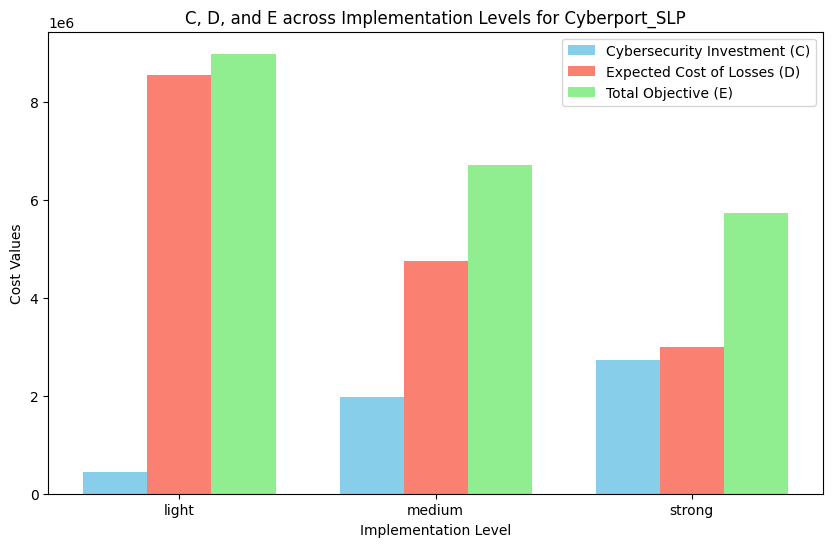

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pulp

def cyberport_slp(c, d, V, q, P, r):
    num_controls = len(c)
    num_levels = len(c[0])
    num_components = len(V)
    num_scenarios = len(P)

    # Initialize problem
    prob = pulp.LpProblem("Cyberport_SLP_Minimize_Cost", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((j, l) for j in range(num_controls) for l in range(num_levels)), cat='Binary')
    v = pulp.LpVariable.dicts("v", ((j, k, l) for j in range(num_controls) for k in range(num_components) for l in range(num_levels)), lowBound=0)
    W = pulp.LpVariable.dicts("W", (k for k in range(num_components)), lowBound=0)

    # Define the objective function
    prob += (pulp.lpSum(c[j][l] * u[j, l] for j in range(num_controls) for l in range(num_levels)) +
             pulp.lpSum(pulp.lpSum(P[s] * d[k] * W[k] for k in range(num_components)) for s in range(num_scenarios))), "Total_Cost"

    # Control Selection Constraint: Exactly one level l must be selected for each control j
    for j in range(num_controls):
        prob += pulp.lpSum(u[j, l] for l in range(num_levels)) == 1, f"Control_Selection_{j}"

    # Initial Vulnerability Constraint: Initial vulnerability of component k secured by safeguard j = 1 is equal to its intrinsic vulnerability
    for k in range(num_components):
        prob += pulp.lpSum(v[0, k, l] for l in range(num_levels)) == V[k], f"Initial_Vulnerability_{k}"

    # Intermediate Vulnerability Constraint
    for j in range(num_controls - 1):  # skip the last control as it has no next control
        for k in range(num_components):
            prob += (pulp.lpSum(r[j][k][l] * v[j, k, l] for l in range(num_levels)) ==
                     pulp.lpSum(v[j + 1, k, l] for l in range(num_levels))), f"Intermediate_Vulnerability_{j}_{k}"

    # Final Vulnerability Constraint
    for k in range(num_components):
        prob += (pulp.lpSum(r[num_controls - 1][k][l] * v[num_controls - 1, k, l] for l in range(num_levels)) ==
                 W[k]), f"Final_Vulnerability_{k}"

    # Implemented Controls Constraint
    for j in range(num_controls):
        for k in range(num_components):
            for l in range(num_levels):
                prob += v[j, k, l] <= u[j, l], f"Implemented_Controls_{j}_{k}_{l}"

    # Solve the problem
    prob.solve()

    # Extract implemented controls and calculate cybersecurity metrics
    control_cybersecurity_values = []
    implemented_controls = []
    C = 0  # Cybersecurity Investment
    H = 0  # Cybersecurity value of control portfolio
    for j in range(num_controls):
        for s in range(num_scenarios):
            # Calculate hj, the cybersecurity value for each control j
            hj = sum(P[s] * d[k] * (1 - r[j][k][1]) * V[k] for k in range(num_components)) - sum(c[j])
            control_cybersecurity_values.append(hj)
            for l in range(num_levels):
                if u[j, l].varValue > 0:
                    if l > 0 and implemented_controls == []:
                        implemented_controls.append((j+1))
                    elif l > 0 and implemented_controls[-1] != (j+1):
                        implemented_controls.append((j+1))
                    if hj > 0:
                        C += c[j][l]
                        H += hj * u[j, l].varValue

    # Calculate expected cost of losses (D)
    D = sum(sum(P[s] * d[k] * W[k].varValue for k in range(num_components)) for s in range(num_scenarios))

    # Calculate total objective function (E)
    E = pulp.value(prob.objective)

    C_alt = E - D

    # Display the results
    print()
    print("Status:", pulp.LpStatus[prob.status])
    print("Cybersecurity Investment (C):", C_alt/1000)
    print("Expected Cost of Losses (D):", D/1000)
    print("Objective Function (E):", E/1000)
    # print("Cybersecurity Value of Control Portfolio (H):", H)
    print("Implemented Controls:", implemented_controls)
    print()


    return C_alt, D, E, H, implemented_controls

# Define function to calculate Ps for each scenario in S
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

# Define function to calculate pk for each component k in K based on scenario probabilities
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

# Input parameters
I = list(range(10))      # 10 threats
J = list(range(20))      # 20 controls
K = list(range(10))      # 10 components
S = list(range(1024))    # 1024 cyberattack scenarios

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]

cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]

pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I,pi)

# Generate r for each control, component, and level based on vulnerability Vk and control effectiveness q
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]

implementation_levels = ["light", "medium", "strong"]
C_array = []
D_array = []
E_array = []
controls_array = []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c=[]
    if implementation_level == "light":
        c = [[0, cj1[i] * 1000] for i in range(len(cj1))]
    elif implementation_level == "medium":
        c = [[0, cj1[i] * 5 * 1000] for i in range(len(cj1))]
    elif implementation_level == "strong":
        c = [[0, cj1[i] * 10 * 1000] for i in range(len(cj1))]
    r = np.zeros((len(c), len(Vk), len(c[0])))
    for j in range(len(c)):
        for k in range(len(Vk)):
            for l in range(len(c[j])):
                r[j][k][l] = Vk[k] ** (q[j] * c[j][l])
    # Solve the model
    C, D, E, H, implemented_controls = cyberport_slp(c, dk, Vk, q, P, r)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Bar positions for each variable
x = np.arange(len(implementation_levels))
width = 0.25  # Width of each bar

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each of C, D, and E as grouped bars
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')

# Labels and formatting
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_SLP")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()

# Display the plot
plt.show()


## With Network (DAG)

Implementation Level: light
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shriya/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f8f3625d52514692ba4a1a3b699b33f5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f8f3625d52514692ba4a1a3b699b33f5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 645 COLUMNS
At line 2428 RHS
At line 3069 BOUNDS
At line 3110 ENDATA
Problem MODEL has 640 rows, 450 columns and 1672 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 8.94869e+06 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 35 strengthened rows, 10 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 11 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 10 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 9 strengthened rows, 0 substitutions
Cgl00

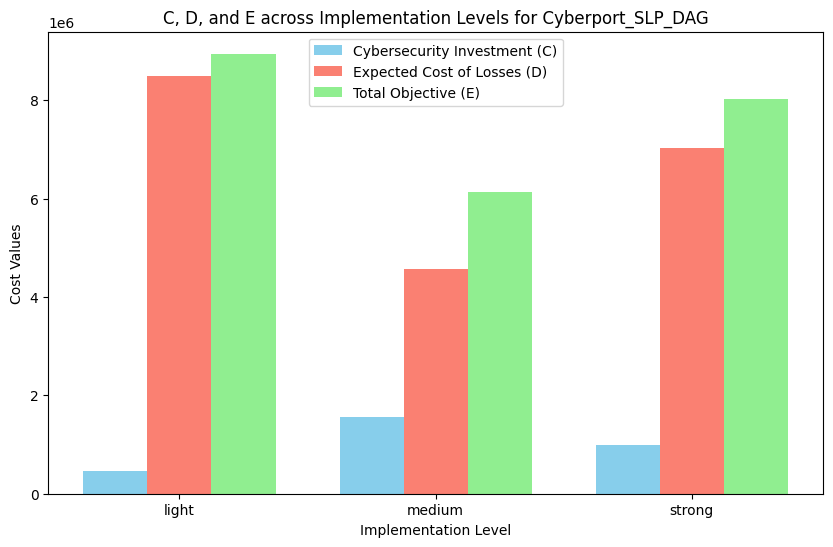

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pulp

def cyberport_slp(c, d, V, q, P, r, q_ih):
    num_controls = len(c)
    num_levels = len(c[0])
    num_components = len(V)
    num_scenarios = len(P)

    # Initialize problem
    prob = pulp.LpProblem("Cyberport_SLP_Minimize_Cost", pulp.LpMinimize)

    # Define decision variables
    u = pulp.LpVariable.dicts("u", ((j, l) for j in range(num_controls) for l in range(num_levels)), cat='Binary')
    v = pulp.LpVariable.dicts("v", ((j, k, l) for j in range(num_controls) for k in range(num_components) for l in range(num_levels)), lowBound=0)
    W = pulp.LpVariable.dicts("W", (k for k in range(num_components)), lowBound=0)

    # Define the objective function
    prob += (pulp.lpSum(c[j][l] * u[j, l] for j in range(num_controls) for l in range(num_levels)) +
             pulp.lpSum(pulp.lpSum(P[s] * d[k] * W[k] for k in range(num_components)) for s in range(num_scenarios))), "Total_Cost"

    # Control Selection Constraint: Exactly one level l must be selected for each control j
    for j in range(num_controls):
        prob += pulp.lpSum(u[j, l] for l in range(num_levels)) == 1, f"Control_Selection_{j}"

    # Initial Vulnerability Constraint: Initial vulnerability of component k secured by safeguard j = 1 is equal to its intrinsic vulnerability
    for k in range(num_components):
        prob += pulp.lpSum(v[0, k, l] for l in range(num_levels)) == V[k], f"Initial_Vulnerability_{k}"

    # Intermediate Vulnerability Constraint
    for j in range(num_controls - 1):  # skip the last control as it has no next control
        for k in range(num_components):
            prob += (pulp.lpSum(r[j][k][l] * v[j, k, l] for l in range(num_levels)) ==
                     pulp.lpSum(v[j + 1, k, l] for l in range(num_levels))), f"Intermediate_Vulnerability_{j}_{k}"

    # Final Vulnerability Constraint
    for k in range(num_components):
        prob += (pulp.lpSum(r[num_controls - 1][k][l] * v[num_controls - 1, k, l] for l in range(num_levels)) ==
                 W[k]), f"Final_Vulnerability_{k}"

    # Implemented Controls Constraint
    for j in range(num_controls):
        for k in range(num_components):
            for l in range(num_levels):
                prob += v[j, k, l] <= u[j, l], f"Implemented_Controls_{j}_{k}_{l}"
    
     # Adjust vulnerability values with propagation probabilities
    for i in range(num_components):
        propagated_vulnerability = pulp.lpSum(q_ih[h, i] * W[h] for h in range(num_components) if q_ih[h, i] > 0)
        prob += W[i] >= propagated_vulnerability

    # Solve the problem
    prob.solve()

    # Extract implemented controls and calculate cybersecurity metrics
    control_cybersecurity_values = []
    implemented_controls = []
    C = 0  # Cybersecurity Investment
    H = 0  # Cybersecurity value of control portfolio
    for j in range(num_controls):
        for s in range(num_scenarios):
            # Calculate hj, the cybersecurity value for each control j
            hj = sum(P[s] * d[k] * (1 - r[j][k][1]) * V[k] for k in range(num_components)) - sum(c[j])
            control_cybersecurity_values.append(hj)
            for l in range(num_levels):
                if u[j, l].varValue > 0:
                    if l > 0 and implemented_controls == []:
                        implemented_controls.append((j+1))
                    elif l > 0 and implemented_controls[-1] != (j+1):
                        implemented_controls.append((j+1))
                    if hj > 0:
                        C += c[j][l]
                        H += hj * u[j, l].varValue

    # Calculate expected cost of losses (D)
    D = sum(sum(P[s] * d[k] * W[k].varValue for k in range(num_components)) for s in range(num_scenarios))

    # Calculate total objective function (E)
    E = pulp.value(prob.objective)

    C_alt = E - D

    # Display the results
    print()
    print("Status:", pulp.LpStatus[prob.status])
    print("Cybersecurity Investment (C):", C_alt/1000)
    print("Expected Cost of Losses (D):", D/1000)
    print("Objective Function (E):", E/1000)
    # print("Cybersecurity Value of Control Portfolio (H):", H)
    print("Implemented Controls:", implemented_controls)
    print()


    return C_alt, D, E, H, implemented_controls

# Define function to calculate Ps for each scenario in S
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

# Define function to calculate pk for each component k in K based on scenario probabilities
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

# Input parameters
I = list(range(1, 11))      # 10 threats
J = list(range(1, 21))      # 20 controls
K = list(range(1, 11))      # 10 components
S = list(range(1, 1025))    # 1024 cyberattack scenarios

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]

cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]

pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I,pi)

# Generate r for each control, component, and level based on vulnerability Vk and control effectiveness q
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]

# Define the adjacency matrix for q_ih (replace the values with your specified probabilities)
q_ih = np.zeros((len(K), len(K)))
q_ih[0, 2] = 0.3
q_ih[0, 3] = 0.7
q_ih[1, 3] = 0.5
q_ih[2, 4] = 0.4
q_ih[2, 5] = 0.8
q_ih[3, 5] = 0.2
q_ih[4, 6] = 0.6
q_ih[5, 7] = 0.9
q_ih[6, 8] = 0.1
q_ih[7, 8] = 0.4
q_ih[8, 9] = 0.7
q_ih[9, 7] = 0.5

implementation_levels = ["light", "medium", "strong"]
C_array = []
D_array = []
E_array = []
controls_array = []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c=[]
    if implementation_level == "light":
        c = [[0, cj1[i] * 1000] for i in range(len(cj1))]
    elif implementation_level == "medium":
        c = [[0, cj1[i] * 5 * 1000] for i in range(len(cj1))]
    elif implementation_level == "strong":
        c = [[0, cj1[i] * 10 * 1000] for i in range(len(cj1))]
    r = np.zeros((len(c), len(Vk), len(c[0])))
    for j in range(len(c)):
        for k in range(len(Vk)):
            for l in range(len(c[j])):
                r[j][k][l] = Vk[k] ** (q[j] * c[j][l])
    # Solve the model
    C, D, E, H, implemented_controls = cyberport_slp(c, dk, Vk, q, P, r, q_ih)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Bar positions for each variable
x = np.arange(len(implementation_levels))
width = 0.25  # Width of each bar

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each of C, D, and E as grouped bars
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')

# Labels and formatting
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_SLP_DAG")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()

# Display the plot
plt.show()


# Cyberport_UBP

## Original

P
{0: 0.036252322031250006, 1: 0.00010908421875000002, 2: 0.024168214687500005, 3: 7.272281250000002e-05, 4: 0.01952048109375, 5: 5.873765625e-05, 6: 0.0130136540625, 7: 3.91584375e-05, 8: 0.036252322031250006, 9: 0.00010908421875000002, 10: 0.024168214687500005, 11: 7.272281250000002e-05, 12: 0.01952048109375, 13: 5.873765625e-05, 14: 0.0130136540625, 15: 3.91584375e-05, 16: 0.012084107343750001, 17: 3.636140625e-05, 18: 0.008056071562500001, 19: 2.4240937500000003e-05, 20: 0.00650682703125, 21: 1.957921875e-05, 22: 0.004337884687500001, 23: 1.3052812500000002e-05, 24: 0.012084107343750001, 25: 3.636140625e-05, 26: 0.008056071562500001, 27: 2.4240937500000003e-05, 28: 0.00650682703125, 29: 1.957921875e-05, 30: 0.004337884687500001, 31: 1.3052812500000002e-05, 32: 0.009063080507812502, 33: 2.7271054687500005e-05, 34: 0.006042053671875001, 35: 1.8180703125000005e-05, 36: 0.0048801202734375, 37: 1.46844140625e-05, 38: 0.003253413515625, 39: 9.789609375e-06, 40: 0.009063080507812502, 41: 

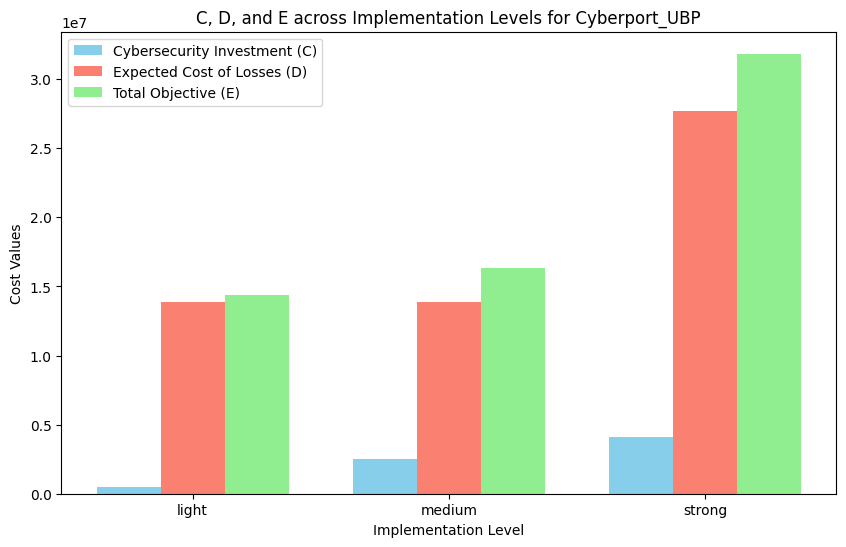

2.5 best solution, best possible 6423860.8 (143766.50 seconds)
Cbc0010I After 7250000 nodes, 137228 on tree, 8101102.5 best solution, best possible 6423860.8 (143777.36 seconds)
Cbc0010I After 7251000 nodes, 137234 on tree, 8101102.5 best solution, best possible 6423860.8 (143787.29 seconds)
Cbc0010I After 7252000 nodes, 137229 on tree, 8101102.5 best solution, best possible 6423860.8 (143796.88 seconds)
Cbc0010I After 7253000 nodes, 137229 on tree, 8101102.5 best solution, best possible 6423860.8 (143805.23 seconds)
Cbc0010I After 7254000 nodes, 137224 on tree, 8101102.5 best solution, best possible 6423860.8 (143812.16 seconds)
Cbc0010I After 7255000 nodes, 137237 on tree, 8101102.5 best solution, best possible 6423860.8 (143820.58 seconds)
Cbc0010I After 7256000 nodes, 137229 on tree, 8101102.5 best solution, best possible 6423860.8 (143828.36 seconds)
Cbc0010I After 7257000 nodes, 137232 on tree, 8101102.5 best solution, best possible 6423860.8 (143836.29 seconds)
Cbc0010I After 72

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pulp

def cyberport_ubp(c, d, V, q, h, pk):
    num_controls = len(c)
    num_components = len(V)

    print("h")
    print(h)
    print("c")
    print(c)

    u = np.zeros(num_controls)
    for j in range(num_controls):
        if h[j] > c[j][1]:
            u[j] = 1

    # Extract implemented controls and calculate cybersecurity metrics
    implemented_controls = []
    C = 0  # Cybersecurity Investment
    D = 0
    for j in range(num_controls):
        if u[j] == 1:
            implemented_controls.append((j+1))

    for j in range(num_controls):
        if u[j] == 1:
            C += c[j][1]

    for j in range(num_controls):
        if (u[j]==0):
            for k in range(num_components):
                D += pk[k] * d[k]
        else:
            for k in range(num_components):
                D += pk[k] * d[k] * q[j]

    # Calculate total objective function (E)
    E = C + D

    # Display the results
    print()
    # print("Status:", pulp.LpStatus[prob.status])
    print("Cybersecurity Investment (C):", C/1000)
    print("Expected Cost of Losses (D):", D/1000)
    print("Objective Function (E):", E/1000)
    # print("Cybersecurity Value of Control Portfolio (H):", H)
    print("Implemented Controls:", implemented_controls)
    print()


    return C, D, E, implemented_controls

# Define function to calculate Ps for each scenario in S
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

# Define function to calculate pk for each component k in K based on scenario probabilities
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

def calculate_h(P,d,r,V,c):
    num_controls = len(c)
    num_components = len(V)
    num_scenarios = len(P)

    h = [0] * num_controls

    for j in range(num_controls):
        for s in range(num_scenarios):
            for k in range(num_components):
                h[j] = sum(P[s] * d[k] * (1 - r[j][k][1]) * V[k] for k in range(num_components))
                h[j] *= 10000000
    return h

# Input parameters
I = list(range(10))      # 10 threats
J = list(range(20))      # 20 controls
K = list(range(10))      # 10 components
S = list(range(1024))    # 1024 cyberattack scenarios

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]

cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]

pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I,pi)

print("P")
print(P)

# Generate r for each control, component, and level based on vulnerability Vk and control effectiveness q
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]

implementation_levels = ["light", "medium", "strong"]
C_array = []
D_array = []
E_array = []
controls_array = []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c=[]
    if implementation_level == "light":
        c = [[0, cj1[i] * 1000] for i in range(len(cj1))]
    elif implementation_level == "medium":
        c = [[0, cj1[i] * 5 * 1000] for i in range(len(cj1))]
    elif implementation_level == "strong":
        c = [[0, cj1[i] * 10 * 1000] for i in range(len(cj1))]
    r = np.zeros((len(c), len(Vk), len(c[0])))
    for j in range(len(c)):
        for k in range(len(Vk)):
            for l in range(len(c[j])):
                r[j][k][l] = Vk[k] ** (q[j] * c[j][l])
    # print(r)
    h = calculate_h(P,dk,r,Vk,c)

    # Solve the model
    C, D, E, implemented_controls = cyberport_ubp(c, dk, Vk, q, h, pk)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Bar positions for each variable
x = np.arange(len(implementation_levels))
width = 0.25  # Width of each bar

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each of C, D, and E as grouped bars
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')

# Labels and formatting
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_UBP")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()

# Display the plot
plt.show()


## With Network (DAG)

Implementation Level: light
h
[np.float64(52483.88424118929), np.float64(33937.408288119586), np.float64(75688.35371587891), np.float64(201773.55482674474), np.float64(19426.62046856779), np.float64(60521.0961913298), np.float64(177424.6266642523), np.float64(93516.64635276761), np.float64(31397.20964369112), np.float64(95964.04786495901), np.float64(80994.89333735975), np.float64(156497.24386781215), np.float64(77107.13047277601), np.float64(150483.1788106025), np.float64(1817.231476332759), np.float64(238260.0817821333), np.float64(74150.18342033804), np.float64(57974.07941727624), np.float64(143721.6195617263), np.float64(69667.19108685038)]
c
[[0, 10000], [0, 20000], [0, 10000], [0, 35000], [0, 20000], [0, 10000], [0, 50000], [0, 45000], [0, 10000], [0, 30000], [0, 15000], [0, 40000], [0, 10000], [0, 60000], [0, 62000], [0, 58000], [0, 20000], [0, 40000], [0, 26000], [0, 10000]]

Cybersecurity Investment (C): 499.0
Expected Cost of Losses (D): 23274.665387838682
Objective Function 

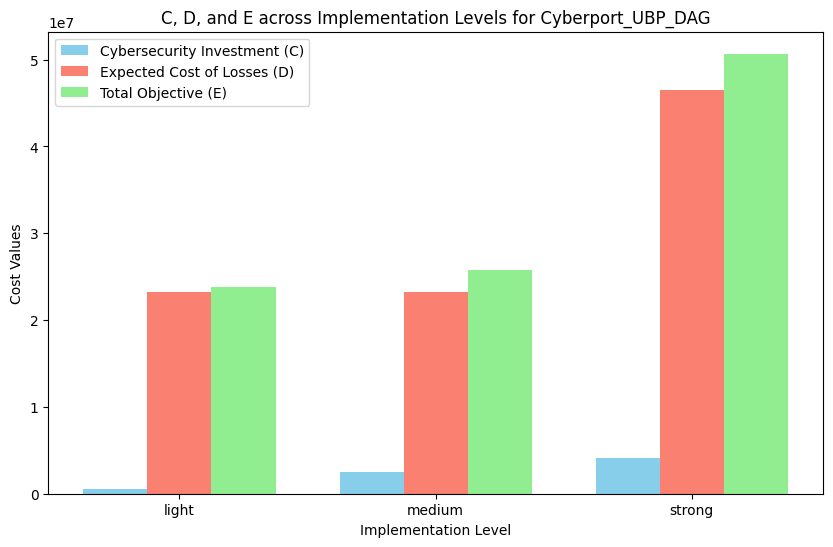

bc0010I After 6491000 nodes, 33003 on tree, 11401370 best solution, best possible 10823126 (147988.56 seconds)
Cbc0010I After 6492000 nodes, 32989 on tree, 11401370 best solution, best possible 10823126 (147996.20 seconds)
Cbc0010I After 6493000 nodes, 33002 on tree, 11401370 best solution, best possible 10823126 (148003.79 seconds)
Cbc0010I After 6494000 nodes, 32999 on tree, 11401370 best solution, best possible 10823126 (148012.48 seconds)
Cbc0010I After 6495000 nodes, 32992 on tree, 11401370 best solution, best possible 10823126 (148022.45 seconds)
Cbc0010I After 6496000 nodes, 32993 on tree, 11401370 best solution, best possible 10823126 (148030.30 seconds)
Cbc0010I After 6497000 nodes, 32992 on tree, 11401370 best solution, best possible 10823126 (148037.87 seconds)
Cbc0010I After 6498000 nodes, 33005 on tree, 11401370 best solution, best possible 10823126 (148046.55 seconds)
Cbc0010I After 6499000 nodes, 33015 on tree, 11401370 best solution, best possible 10823126 (148054.52 se

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pulp

def cyberport_ubp(c, d, V, q, h, pk, q_ih):
    num_controls = len(c)
    num_components = len(V)

    print("h")
    print(h)
    print("c")
    print(c)

    u = np.zeros(num_controls)
    for j in range(num_controls):
        if h[j] > c[j][1]:
            u[j] = 1

    # Extract implemented controls and calculate cybersecurity metrics
    implemented_controls = []
    C = 0  # Cybersecurity Investment
    D = 0
    for j in range(num_controls):
        if u[j] == 1:
            implemented_controls.append((j+1))

    for j in range(num_controls):
        if u[j] == 1:
            C += c[j][1]

    for j in range(num_controls):
        if (u[j]==0):
            for k in range(num_components):
                mult = 1.0
                for n in range(num_components):
                    if q_ih[n, k] > 0:
                        mult *= 1 + q_ih[n, k]
                D += pk[k] * d[k] * mult
        else:
            for k in range(num_components):
                mult = 1.0
                for n in range(num_components):
                    if q_ih[n, k] > 0:
                        mult *= 1 + q_ih[n, k]
                D += pk[k] * d[k] * q[j] * mult

    # Calculate total objective function (E)
    E = C + D

    # Display the results
    print()
    # print("Status:", pulp.LpStatus[prob.status])
    print("Cybersecurity Investment (C):", C/1000)
    print("Expected Cost of Losses (D):", D/1000)
    print("Objective Function (E):", E/1000)
    # print("Cybersecurity Value of Control Portfolio (H):", H)
    print("Implemented Controls:", implemented_controls)
    print()


    return C, D, E, implemented_controls

# Define function to calculate Ps for each scenario in S
def calculate_scenario_probabilities(I, pi):
    num_scenarios = 2 ** len(I)
    scenario_probabilities = {}

    for s in range(num_scenarios):
        binary_representation = f"{s:0{len(I)}b}"
        Is = [int(bit) for bit in binary_representation]
        
        # Calculate Ps for scenario s
        Ps = 1
        for i in range(len(I)):
            if Is[i] == 1:
                Ps *= pi[i]
            else:
                Ps *= (1 - pi[i])
        
        scenario_probabilities[s] = Ps

    return scenario_probabilities

# Define function to calculate pk for each component k in K based on scenario probabilities
def calculate_component_probabilities(K, S, pi, scenario_probabilities, aik):
    pk = [0] * len(K)

    for k in range(len(K)):
        for s, Ps in scenario_probabilities.items():
            # Check if scenario s has at least one threat that affects component k
            binary_representation = f"{s:0{len(pi)}b}"
            affects_k = any(aik[i][k] == 1 and int(binary_representation[i]) == 1 for i in range(len(pi)))
            
            if affects_k:
                pk[k] += Ps

    return pk

def calculate_h(P,d,r,V,c):
    num_controls = len(c)
    num_levels = len(c[0])
    num_components = len(V)
    num_scenarios = len(P)

    h = [0] * num_controls

    for j in range(num_controls):
        for s in range(num_scenarios):
            for k in range(num_components):
                h[j] = sum(P[s] * d[k] * (1 - r[j][k][1]) * V[k] for k in range(num_components))
                h[j] *= 10000000
    return h

# Input parameters
I = list(range(10))      # 10 threats
J = list(range(20))      # 20 controls
K = list(range(10))      # 10 components
S = list(range(1024))    # 1024 cyberattack scenarios

Vk = [0.771269, 0.760485, 0.669096, 0.50657, 0.57994, 0.682282, 
      0.697596, 0.992109, 0.977199, 0.993963]

cj1 = [10, 20, 10, 35, 20, 10, 50, 45, 10, 30, 15, 40, 10, 60, 62, 58, 20, 40, 26, 10]

pi = [0.35, 0.25, 0.15, 0.25, 0.20, 0.25, 0.50, 0.35, 0.40, 0.003]
pk = [0.55, 0.003, 0.76, 0.51, 0.70, 0.88, 0.40, 0.90, 0.55, 0.64]
dk_temp = [24, 122, 350, 5, 250, 20, 20, 25, 30, 10000]
dk = [1000 * value for value in dk_temp]
P = calculate_scenario_probabilities(I,pi)

# print("P")
# print(P)

# Define the adjacency matrix for q_ih 
q_ih = np.zeros((len(K), len(K)))
q_ih[0, 2] = 0.3
q_ih[0, 3] = 0.7
q_ih[1, 3] = 0.5
q_ih[2, 4] = 0.4
q_ih[2, 5] = 0.8
q_ih[3, 5] = 0.2
q_ih[4, 6] = 0.6
q_ih[5, 7] = 0.9
q_ih[6, 8] = 0.1
q_ih[7, 8] = 0.4
q_ih[8, 9] = 0.7
q_ih[9, 7] = 0.5

# Generate r for each control, component, and level based on vulnerability Vk and control effectiveness q
q_temp = [6.09209, 1.89873, 9.21892, 9.57156, 1.05726, 7.14106, 5.51532, 2.63135, 3.49604, 4.07247, 
          6.65212, 5.75807, 9.42022, 3.63525, 0.0308876, 7.55598, 4.50103, 1.70122, 7.87748, 8.37808]
q = [value * 1e-5 for value in q_temp]

implementation_levels = ["light", "medium", "strong"]
C_array = []
D_array = []
E_array = []
controls_array = []

for implementation_level in implementation_levels:
    print(f"Implementation Level: {implementation_level}")
    c=[]
    if implementation_level == "light":
        c = [[0, cj1[i] * 1000] for i in range(len(cj1))]
    elif implementation_level == "medium":
        c = [[0, cj1[i] * 5 * 1000] for i in range(len(cj1))]
    elif implementation_level == "strong":
        c = [[0, cj1[i] * 10 * 1000] for i in range(len(cj1))]
    r = np.zeros((len(c), len(Vk), len(c[0])))
    for j in range(len(c)):
        for k in range(len(Vk)):
            for l in range(len(c[j])):
                r[j][k][l] = Vk[k] ** (q[j] * c[j][l])
    # print(r)
    h = calculate_h(P,dk,r,Vk,c)

    # Solve the model
    C, D, E, implemented_controls = cyberport_ubp(c, dk, Vk, q, h, pk, q_ih)
    C_array.append(C)
    D_array.append(D)
    E_array.append(E)
    controls_array.append(implemented_controls)

# Bar positions for each variable
x = np.arange(len(implementation_levels))
width = 0.25  # Width of each bar

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting each of C, D, and E as grouped bars
ax.bar(x - width, C_array, width, label='Cybersecurity Investment (C)', color='skyblue')
ax.bar(x, D_array, width, label='Expected Cost of Losses (D)', color='salmon')
ax.bar(x + width, E_array, width, label='Total Objective (E)', color='lightgreen')

# Labels and formatting
ax.set_xlabel("Implementation Level")
ax.set_ylabel("Cost Values")
ax.set_title("C, D, and E across Implementation Levels for Cyberport_UBP_DAG")
ax.set_xticks(x)
ax.set_xticklabels(implementation_levels)
ax.legend()

# Display the plot
plt.show()
